In [1]:
import os
os.chdir('../')
from python_code import local_regression
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
import pandas as pd

## Basic code testing

In [2]:
x_data = np.linspace(0,10,100).reshape(-1,1)
x_target = np.linspace(0,10,1000).reshape(-1,1)
y_data = np.sin(1*x_data) + np.random.normal(0,.3,size=100).reshape(-1,1)

In [3]:
reg = local_regression.Lowess(degree=1)
reg.fit(x_data, y_data)
y_pred, _, _ = reg.predict(x_target)

/Users/juliette/Documents/repos/SDS383D_JF/exercises-06/python_code/local_regression.py:64: UserWarning: can"t calculate CI if y and y_pred are not the same length
  warnings.warn('can"t calculate CI if y and y_pred are not the same length')


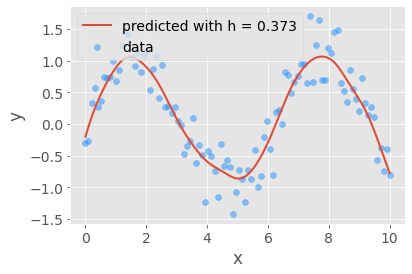

In [4]:
plt.plot(x_target, y_pred, lw=2, label=f'predicted with h = {float(np.round(reg.bandwidth,3))}')
plt.scatter(x_data, y_data, color='dodgerblue', label='data', alpha=.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [5]:
H = reg._calculate_smoothing_matrix(x_target)

## Utilities

In [6]:
df = pd.read_csv('../data/utilities.csv')
df = df.sort_values('temp')

In [7]:
x = df['temp'].to_numpy().reshape(-1,1)
y =  (df['gasbill']/df['billingdays']).to_numpy().reshape(-1,1)

In [8]:
reg = local_regression.Lowess(degree=2)
reg.fit(x,y)
y_pred, lower, upper = reg.predict(x, sig_level = 0.05)

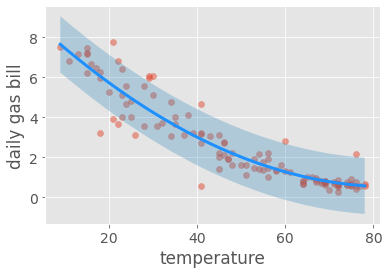

In [9]:
plt.scatter(x, y, alpha =.5)
plt.plot(x, y_pred, color='dodgerblue', lw=3)
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), alpha = .3)
plt.ylabel('daily gas bill')
plt.xlabel('temperature');

In [10]:
reg.bandwidth

array([86.61405138])

In [11]:
#hs = np.linspace(1,1000, 100)
#plt.plot([reg._objective_function_leave_one_out(h) for h in hs])

In [12]:
residuals = y - y_pred

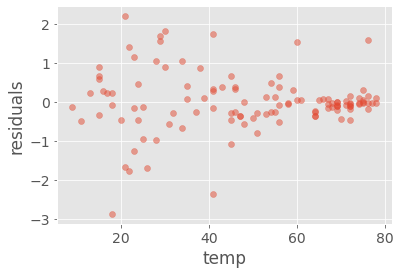

In [13]:
plt.scatter(x, residuals, alpha=.5)
plt.xlabel('temp')
plt.ylabel('residuals');

In [28]:
def gaussian_kernel(x):
    """
    Takes in an array of x values and returns corresponding Gaussian kernel values
    Parameters
    ----------
     x: array_like
        An array of x values
    Returns
    -------
    gaussian_kernel(x): array_like
        An array of same length as x with corresponding kernel values
    """
    return np.array([1.0/(2.0*np.pi)**.5 * np.exp(-i**2/2) for i in x])

def weight_calc(x, x_star, h, kernel_func=gaussian_kernel):
    """
    Evaluates the normalized weights for based on a kernel function
    Parameters
    ----------
    x: array_like
        the array of x values from the data
    x_star: float
        The x value corresponding to the desired prediction location
    h: float
        The bandwidth
    kernel_func: function
        The desired kernel function. Default is gaussian
    Returns
    -------
    weight_calc: array_like
        The weight of each x data point for the desired prediction location
    """
    raw_weights = 1.0/h*kernel_func((x-x_star)/h)
    norm_weights =  np.array(raw_weights/np.sum(raw_weights))
    return norm_weights

def pred(x,y, x_star, h, kernel_func=gaussian_kernel):

    """
    Makes predictions for an array x_star for a given dataset of x and y
    Parameters
    ----------
    x: array_like
        the array of x values from the data
    y: array_like
        the array of corresponding y values
    x_star: float
        The x value corresponding to the desired prediction location
    h: float
        The bandwidth
    kernel_func: function
        The desired kernel function. Default is gaussian
    Returns
    -------
    y_star: array_like
        The predicted values corresponding to x_star
    """

    y_star = np.zeros(len(x_star))
    for i, x_val in enumerate(x_star):
        weights = weight_calc(x, x_val,h, kernel_func)
        y_star[i] = weights@y #matrix multiplciation

    return y_star

def train_test_split(x,y, test_size=0.25):

    """
    Splits a dataset into a training and test set
    Parameters
    ----------
    x: array_like
        The x values for a dataset
    y: array_like
        The corresponding y values from the dataset
    test_size: float
        The fraction of the dataset to allocate to the test set
    Returns
    -------
    train_x: array_like
        The x values from the training set
    train_y: array_like
        The corresponding y values from the training set
    test_x: array_like
        The x values from the test set
    test_y: array_like
        The corresponding y values from the test set
    Raises
    ------
    ValueError
        when x and y are not the same length
    """
    if len(x) != len(y):
        raise ValueError('x and y should be the same length')

    #First determine the absolute number of points for the test set
    test_size = int(round(test_size*len(x)))

    #Randomly select indices for the test set
    test_indices = np.random.choice(np.array(range(len(x))), test_size, replace=False)

    #Then make the test set
    test_x = np.array(x)[test_indices]
    test_y = np.array(y)[test_indices]

    #Then make the training set 
    train_x = np.delete(np.array(x),test_indices)
    train_y = np.delete(np.array(y),test_indices)

    return train_x, train_y, test_x, test_y

def error_calc(x1, x2):
    """
    Determines the mean squared error between two vectors.
    x1 and x2 must be the same length
    Parameters
    ----------
    x1 : array_like
        The first array
    x2: array_like
        The second array
    Returns
    -------
    mean_error: float
        The average squared error between x1 and x2
    Raises:
    ------
    ValueError
        if the two arrays are not the same length
    """
    if len(x1) != len(x2):
        raise ValueError('arrays must be the same length')

    total_error = 0.0
    for i in range(len(x1)):
        total_error = total_error + (x1[i] - x2[i])**2

    mean_error = total_error / float(len(x1))
    return mean_error

def local_poly_estimate(x_data, y_data,x_star,h, kernel = gaussian_kernel, d=2):
    """
    Description
    Parameters
    ----------
    x_data: array_like
        The x values from the observed data
    y_data: array_like
        The y values from the observed data
    x_star: array_like
        The x locations to make predictions for
    h: Float
        The bandwidth
    kernel: func
        The kernel function to use
    d: int
        The order of the polynomial
    Returns
    -------
    y_star: array_like
        The predicted y_values corresponding to x_star
    H: array_like
        The projection matrix 
    """
    #Creating numpy array versions of the x and y data so everything plays nicely
    x = np.array(x_data)
    y = np.array(y_data)

    y_star = np.zeros(len(x_star))
    #initialize H, the projection matrix
    H = np.zeros([len(x_star), len(x_data)])
    #Creating the R matrix
    for i,x_val in enumerate(x_star):
        #Making the general R matrix
        R = np.zeros([len(x),d])
        for j in range(d):
            R[:,j] = (x - x_val)**j
        #Making the W matrix
        W = np.diag(1/h * kernel((x-x_val)/h))

        a_hat = inv(np.transpose(R)@W@R)@np.transpose(R)@W@y
        H[i,:] = (inv(np.transpose(R)@W@R)@np.transpose(R)@W)[0,:]
        y_star[i] = a_hat[0]


    return y_star, H

def leave_one_out(x_data, y_data, estimator,h, kernel=gaussian_kernel):
    #Creating numpy array versions of the x and y data so everything plays nicely
    x = np.array(x_data)
    y = np.array(y_data)
    error = np.zeros(len(x_data))
    for i in range(len(x_data)):
        y_star = estimator(np.delete(x,i), np.delete(y,i), [x[i]], h, kernel)[0]
        error[i] = error_calc(y_star, [y_data[i]])
    return np.mean(error)



In [29]:
from scipy.stats import multivariate_normal
from scipy.spatial.distance import euclidean
from scipy.optimize import minimize
from numpy.linalg import inv

In [44]:


#Getting the optimal h
h = minimize(lambda b: leave_one_out(x.flatten(), y.flatten(), local_poly_estimate, b), 1.0, bounds=[(1, None)])['x']
print(h)
#Generating array of x values we want to predict
#x_star = np.linspace(min(x_data),max(x_data),50)
y_star, H_pear = local_poly_estimate(x.flatten(), y.flatten(), x.flatten(), 20)




[6.87594026]


In [45]:
reg.bandwidth

array([86.61405138])

In [46]:
H = reg._calculate_smoothing_matrix(x)

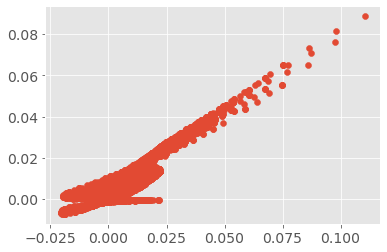

In [47]:
plt.scatter(H, H_pear)

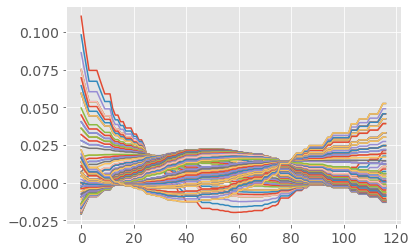

In [48]:
plt.plot(H);

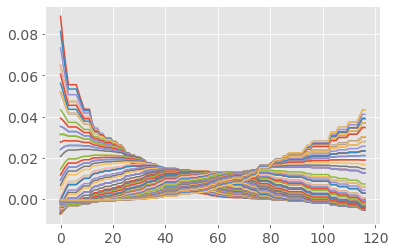

In [49]:
plt.plot(H_pear);

In [54]:
reg.bandwidth

array([0.37267839])

In [58]:
reg = local_regression.Lowess(degree=1)
reg.fit(x_data,y_data)
y_pred, lower, upper = reg.predict(x_data, sig_level = 0.05)
H = reg._calculate_smoothing_matrix(x_data)
y_star, H_pear = local_poly_estimate(x_data.flatten(), y_data.flatten(), x_data.flatten(), reg.bandwidth)


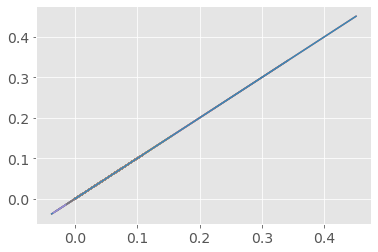

In [60]:
plt.plot(H, H_pear);